This program uses Shuffle-Split Cross-Validation instead of K-Fold Cross-Validation to select the best hyperparameters for models.
The results are noticeably better in knn, slightly better in dt, and no changes in rf.

In [33]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# For model training and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score




Fetch and Load the Dataset

In [34]:
from sklearn.datasets import fetch_openml

heart_disease = pd.read_csv('/content/cleveland_heart_disease_data.csv')

X = heart_disease.drop('num', axis=1)

y = heart_disease['num']



In [35]:
#Explore the Dataset
print("Features shape:", X.shape)
print("Targets shape:", y.shape)
print("\nFirst five rows of features:")
print(X.head())

print("\nFirst five rows of target:")
print(y.head())

Features shape: (303, 13)
Targets shape: (303,)

First five rows of features:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  
0  0.0   6.0  
1  3.0   3.0  
2  2.0   7.0  
3  0.0   3.0  
4  0.0   3.0  

First five rows of target:
0    0
1    2
2    1
3    0
4    0
Name: num, dtype: int64


In [36]:
#Data Preprocessing

# Combine features and target
df = pd.concat([X, y], axis=1)
# Assign column names
column_names = [
    'age',       # 3
    'sex',       # 4
    'cp',        # 9
    'trestbps',  # 10
    'chol',      # 12
    'fbs',       # 16
    'restecg',   # 19
    'thalach',   # 32
    'exang',     # 38
    'oldpeak',   # 40
    'slope',     # 41
    'ca',        # 44
    'thal',      # 51
    'num'        # 58 (the predicted attribute)
]

df.columns = column_names

# Handle Missing Values
# Replace missing values represented as '?' or empty strings with NaN
df.replace(['?', ''], np.nan, inplace=True)

# Convert columns to appropriate data types
df = df.apply(pd.to_numeric, errors='coerce')

# Check for missing values
print(df.isnull().sum())

# Fill missing numerical values with median
for col in ['ca', 'thal', 'oldpeak', 'slope']:
    df[col].fillna(df[col].median(), inplace=True)

# Simplify 'num' to binary classification
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df.drop('num', axis=1, inplace=True)

# Convert 'ca' and 'thal' to integer type before encoding
df['ca'] = df['ca'].astype(int)
df['thal'] = df['thal'].astype(int)

# List of categorical columns
categorical_cols = ['cp', 'restecg', 'slope', 'thal', 'ca']

# One-Hot Encoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64


<ipython-input-36-8fa53d455982>:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


Feature Scaling

Scale numerical features.

In [37]:
# List of numerical columns
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the numerical columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


In [38]:
# Features and target variable
X = df.drop('target', axis=1)
y = df['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

KNN
I use GridSearchCV to find the best hyperparameters for the KNN model.

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ShuffleSplit

# Define the parameter grid for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize the model
knn = KNeighborsClassifier()

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# Initialize GridSearchCV
grid_search_knn = GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search_knn.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search_knn.best_params_)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


In [40]:
# Predict on the test set using KNN
y_pred_knn = grid_search_knn.predict(X_test)

# Evaluation metrics for KNN
print('KNN Model Evaluation:')
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_knn))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_knn))
print('Accuracy Score:', accuracy_score(y_test, y_pred_knn))


KNN Model Evaluation:
Confusion Matrix:
[[30  3]
 [ 3 25]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        33
           1       0.89      0.89      0.89        28

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61

Accuracy Score: 0.9016393442622951


Decision Tree Model

In [41]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [42]
}

dt_clf = DecisionTreeClassifier()

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

grid_search_dt = GridSearchCV(estimator=dt_clf, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

grid_search_dt.fit(X_train, y_train)

print("Best parameters found:", grid_search_dt.best_params_)

y_pred_dt = grid_search_dt.predict(X_test)


Best parameters found: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42}


In [42]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Decision Tree Model Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))
print("Accuracy Score:", accuracy_score(y_test, y_pred_dt))


Decision Tree Model Evaluation:
Confusion Matrix:
[[29  4]
 [12 16]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.88      0.78        33
           1       0.80      0.57      0.67        28

    accuracy                           0.74        61
   macro avg       0.75      0.73      0.73        61
weighted avg       0.75      0.74      0.73        61

Accuracy Score: 0.7377049180327869


In [43]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [42]
}

rf_clf = RandomForestClassifier()

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

grid_search_rf = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

grid_search_rf.fit(X_train, y_train)

print('Best parameters found:', grid_search_rf.best_params_)

y_pred_rf = grid_search_rf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

print("\nAccuracy Score:", accuracy_score(y_test, y_pred_rf))


Best parameters found: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 42}
Confusion Matrix:
[[30  3]
 [ 4 24]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90        33
           1       0.89      0.86      0.87        28

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61


Accuracy Score: 0.8852459016393442


Compare Model Performance

In [44]:
from sklearn.metrics import accuracy_score

# KNN Accuracy
knn_accuracy = accuracy_score(y_test, y_pred_knn)

# Decision Tree Accuracy
dt_accuracy = accuracy_score(y_test, y_pred_dt)

# Random Forest Accuracy
rf_accuracy = accuracy_score(y_test, y_pred_rf)

# Print Accuracy
print(f'KNN Accuracy: {knn_accuracy * 100:.2f}%')
print(f'Decision Tree Accuracy: {dt_accuracy * 100:.2f}%')
print(f'Random Forest Accuracy: {rf_accuracy * 100:.2f}%')


KNN Accuracy: 90.16%
Decision Tree Accuracy: 73.77%
Random Forest Accuracy: 88.52%


Visualizing the Performance of KNN, Decision Tree and Random Forest Models on the Heart Disease Dataset

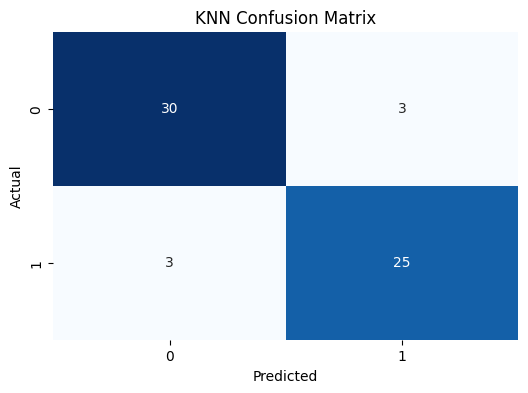

In [45]:
# Confusion Matrix for KNN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


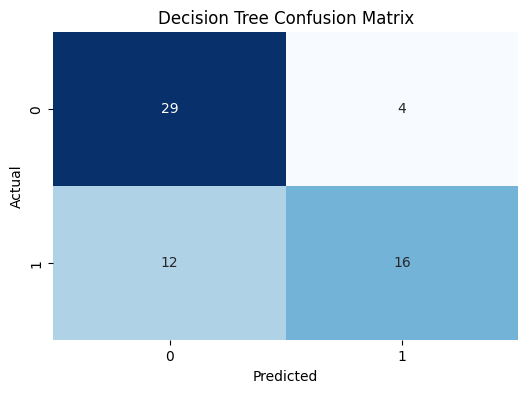

In [46]:
# Confusion Matrix for Decision Tree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix for Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Plot confusion matrix for Decision Tree
plt.figure(figsize=(6,4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


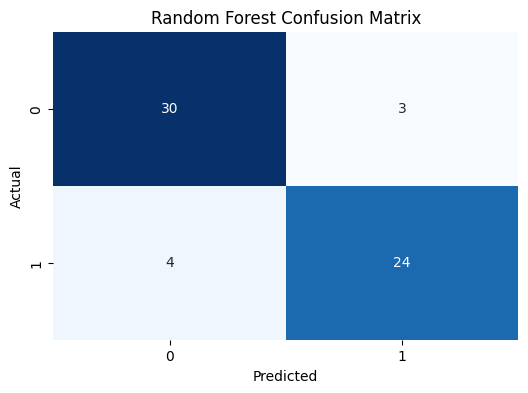

In [47]:
# Confusion Matrix for Random Forest
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix for Random Forest
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


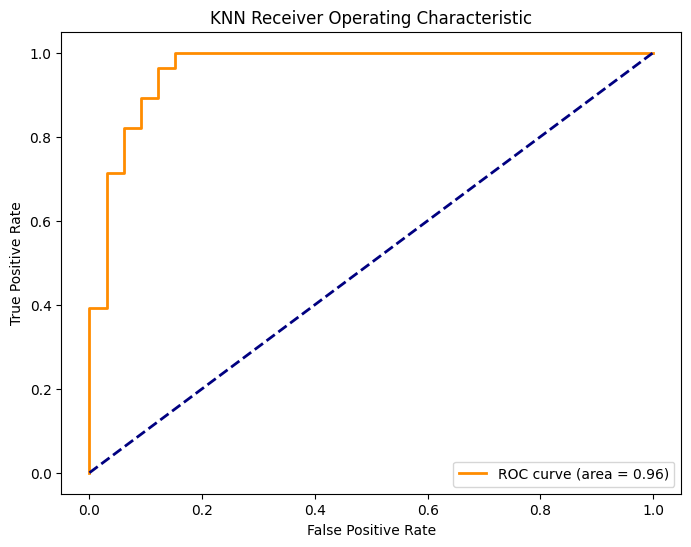

In [48]:
# ROC Curve for KNN
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the positive class
y_pred_proba_knn = grid_search_knn.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_proba_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('KNN Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


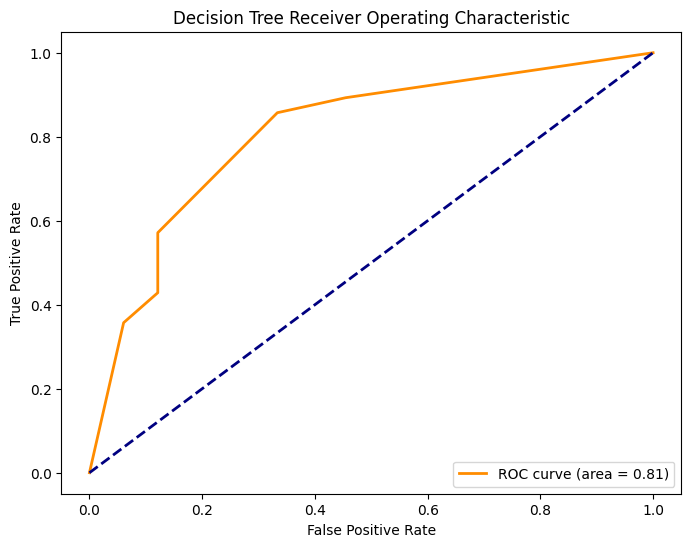

In [49]:
# ROC Curve for Decision Tree
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the positive class
y_pred_proba_dt = grid_search_dt.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_dt)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Decision Tree Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


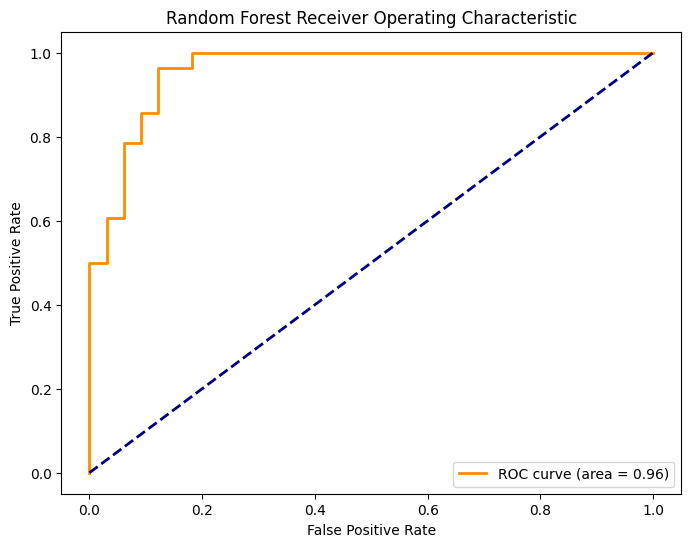

In [50]:
# ROC Curve for Random Forest
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the positive class
y_pred_proba_rf = grid_search_rf.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Random Forest Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


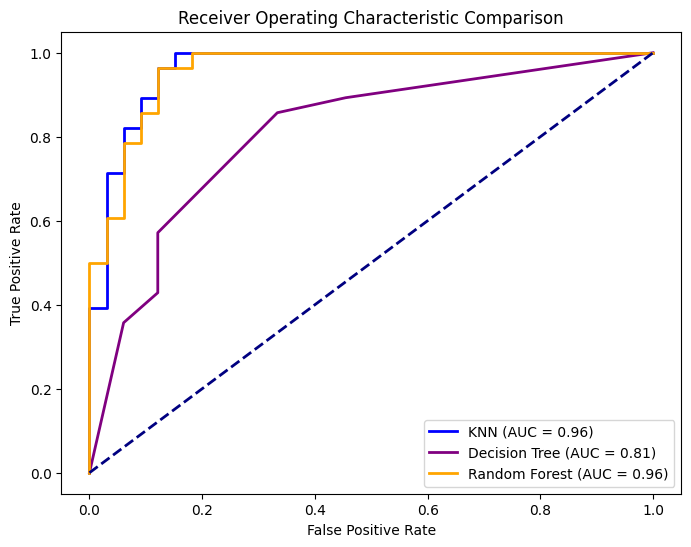

In [51]:
# Combined ROC Curves for KNN, Decision Tree, and Random Forest
plt.figure(figsize=(8, 6))

# KNN ROC
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label='KNN (AUC = %0.2f)' % roc_auc_knn)

# Decision Tree ROC
plt.plot(fpr_dt, tpr_dt, color='purple', lw=2, label='Decision Tree (AUC = %0.2f)' % roc_auc_dt)

# Random Forest ROC
plt.plot(fpr_rf, tpr_rf, color='orange', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)

# Diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot title and labels
plt.title('Receiver Operating Characteristic Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


<ipython-input-52-c1fa36b18744>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_df.Importance, y=feature_importance_df.index, palette='coolwarm')


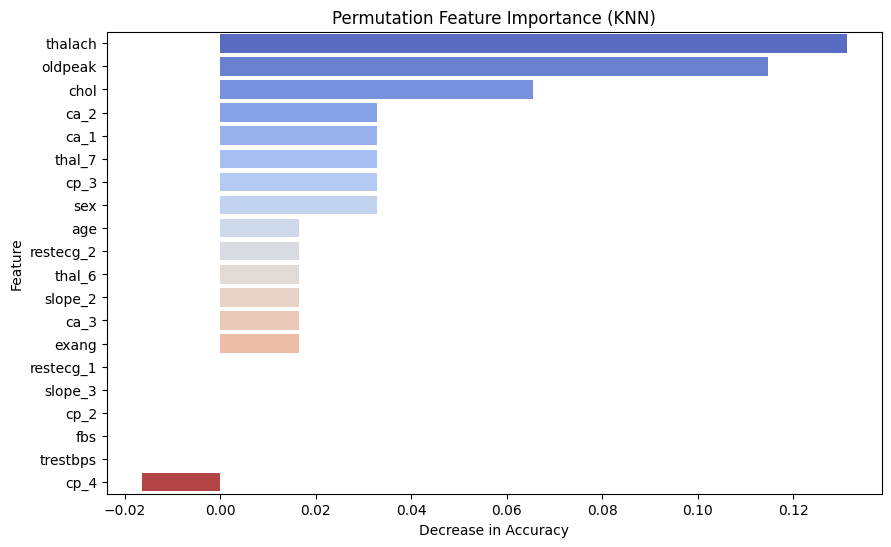

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred)

feature_importances = {}

for col in X_test.columns:
    X_test_permuted = X_test.copy()

    X_test_permuted[col] = np.random.permutation(X_test_permuted[col])

    y_pred_permuted = knn.predict(X_test_permuted)
    permuted_accuracy = accuracy_score(y_test, y_pred_permuted)

    feature_importances[col] = baseline_accuracy - permuted_accuracy

feature_importance_df = pd.DataFrame.from_dict(feature_importances, orient='index', columns=['Importance'])
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_df.Importance, y=feature_importance_df.index, palette='coolwarm')
plt.title('Permutation Feature Importance (KNN)')
plt.xlabel('Decrease in Accuracy')
plt.ylabel('Feature')
plt.show()


<ipython-input-53-0a70cba032a0>:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feature_importance_df['Feature Label'].fillna(feature_importance_df['Feature'], inplace=True)
<ipython-input-53-0a70cba032a0>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


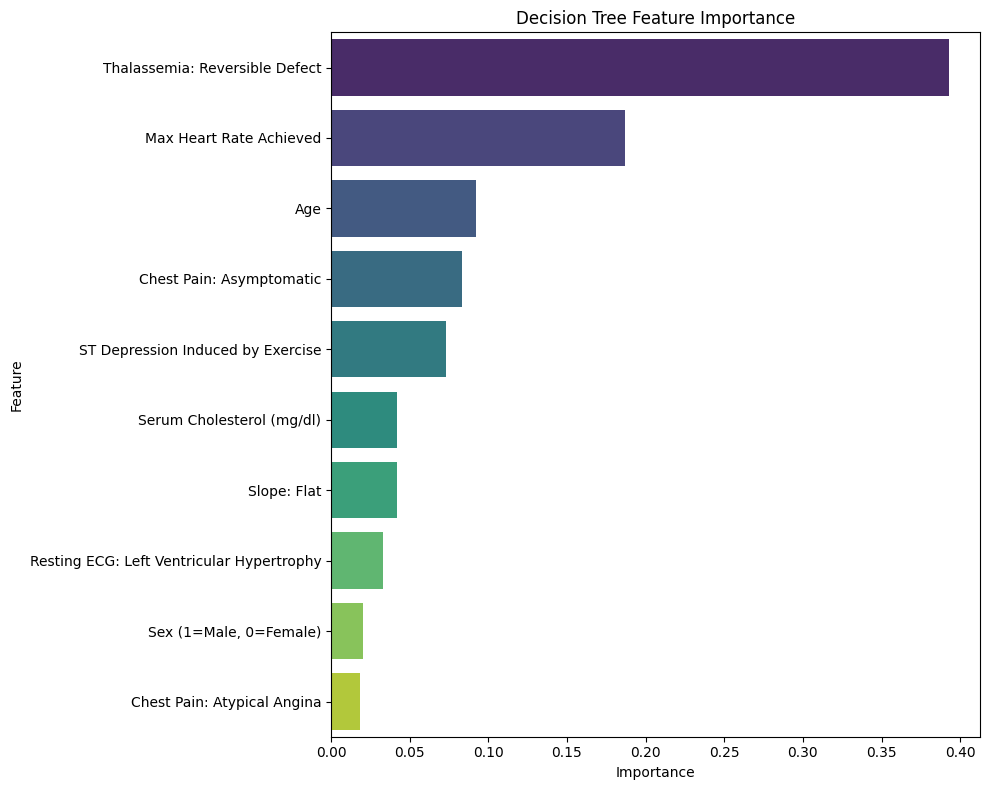

In [53]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

feature_labels = {
    'age': 'Age',
    'sex': 'Sex (1=Male, 0=Female)',
    'trestbps': 'Resting Blood Pressure (mm Hg)',
    'chol': 'Serum Cholesterol (mg/dl)',
    'fbs': 'Fasting Blood Sugar > 120 mg/dl (1=True, 0=False)',
    'thalach': 'Max Heart Rate Achieved',
    'exang': 'Exercise Induced Angina (1=Yes, 0=No)',
    'oldpeak': 'ST Depression Induced by Exercise',
    'cp_2': 'Chest Pain: Atypical Angina',
    'cp_3': 'Chest Pain: Non-Anginal Pain',
    'cp_4': 'Chest Pain: Asymptomatic',
    'restecg_1': 'Resting ECG: ST-T Wave Abnormality',
    'restecg_2': 'Resting ECG: Left Ventricular Hypertrophy',
    'slope_2': 'Slope: Flat',
    'slope_3': 'Slope: Downsloping',
    'thal_6': 'Thalassemia: Fixed Defect',
    'thal_7': 'Thalassemia: Reversible Defect',
    'ca_1': 'Number of Major Vessels: 1',
    'ca_2': 'Number of Major Vessels: 2',
    'ca_3': 'Number of Major Vessels: 3',
    'ca_4': 'Number of Major Vessels: 4',
}

dt_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_clf.fit(X_train, y_train)

importances = dt_clf.feature_importances_
feature_names = X_train.columns.tolist()

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
feature_importance_df['Feature Label'] = feature_importance_df['Feature'].map(feature_labels)
feature_importance_df['Feature Label'].fillna(feature_importance_df['Feature'], inplace=True)
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance',
    y='Feature Label',
    data=feature_importance_df.head(10),
    palette='viridis'
)
plt.title('Decision Tree Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


<ipython-input-54-4ac1e6207b07>:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feature_importance_df['Feature Label'].fillna(feature_importance_df['Feature'], inplace=True)
<ipython-input-54-4ac1e6207b07>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


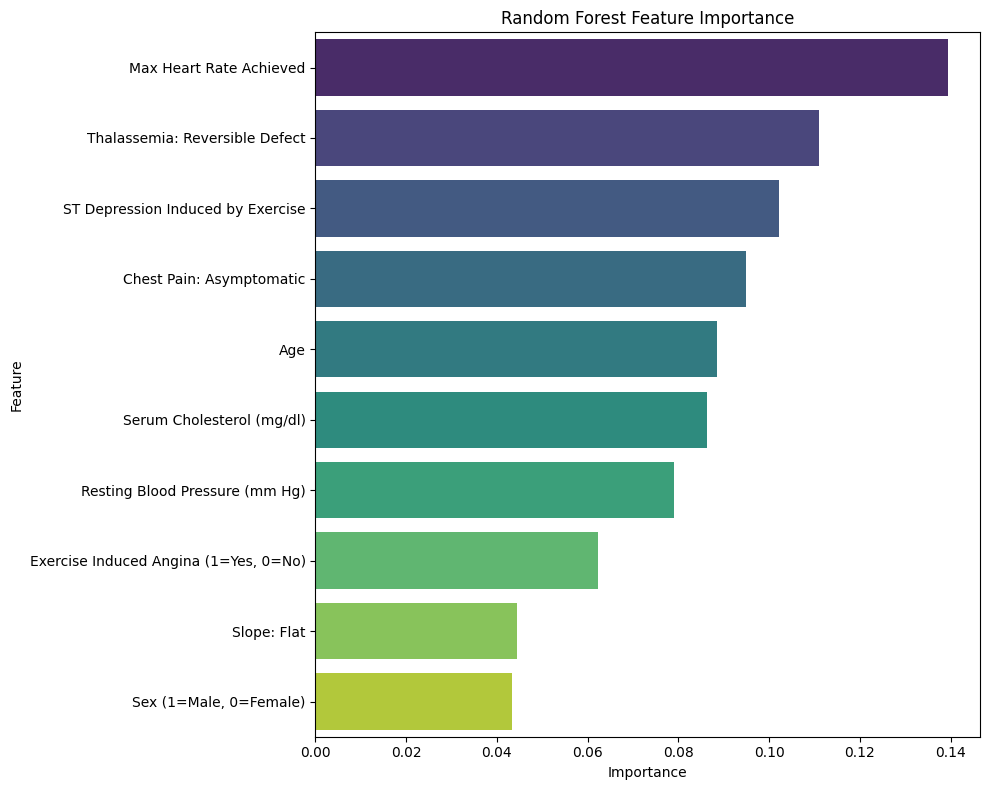

In [54]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

feature_labels = {
    'age': 'Age',
    'sex': 'Sex (1=Male, 0=Female)',
    'trestbps': 'Resting Blood Pressure (mm Hg)',
    'chol': 'Serum Cholesterol (mg/dl)',
    'fbs': 'Fasting Blood Sugar > 120 mg/dl (1=True, 0=False)',
    'thalach': 'Max Heart Rate Achieved',
    'exang': 'Exercise Induced Angina (1=Yes, 0=No)',
    'oldpeak': 'ST Depression Induced by Exercise',
    'cp_2': 'Chest Pain: Atypical Angina',
    'cp_3': 'Chest Pain: Non-Anginal Pain',
    'cp_4': 'Chest Pain: Asymptomatic',
    'restecg_1': 'Resting ECG: ST-T Wave Abnormality',
    'restecg_2': 'Resting ECG: Left Ventricular Hypertrophy',
    'slope_2': 'Slope: Flat',
    'slope_3': 'Slope: Downsloping',
    'thal_6': 'Thalassemia: Fixed Defect',
    'thal_7': 'Thalassemia: Reversible Defect',
    'ca_1': 'Number of Major Vessels: 1',
    'ca_2': 'Number of Major Vessels: 2',
    'ca_3': 'Number of Major Vessels: 3',
    'ca_4': 'Number of Major Vessels: 4',
}

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

importances = rf_clf.feature_importances_
feature_names = X_train.columns.tolist()

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
feature_importance_df['Feature Label'] = feature_importance_df['Feature'].map(feature_labels)
feature_importance_df['Feature Label'].fillna(feature_importance_df['Feature'], inplace=True)
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance',
    y='Feature Label',
    data=feature_importance_df.head(10),
    palette='viridis'
)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
